# Analysis of Benchmarking Results for Partitioned LSMTree

In [1]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
ops = ['put', 'get', 'delete']

In [150]:
figdir = 'figures/partitioned_lsm'
!mkdir -p $figdir

# Loading Data

In [156]:
specs = pd.read_json('results/partitioned_lsm/benchmark_part_lsm_specs.jsonl', lines=True)
print(len(specs))
specs.head()

105


,spec,created_at,events,id,last_modified,status
0,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.321243,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.903595'}]",d4712913-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.903595,cancelled
1,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-29 20:48:46.571357,"[{'msg': 'starting', 'hostname': 'ec2-35-164-210-77.us-west-2.compute.amazonaws.com', 'time': '2...",58db5279-8a7c-11ea-b1d1-00155d010301,2020-04-30T01:53:17.412197,succeeded
2,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 08:59:00.805861,"[{'msg': 'Cancelled as duplicate', 'hostname': 'master', 'time': '2020-04-30T09:35:57.990984'}]",d4712919-8ac0-11ea-b1d1-00155d010301,2020-04-30T09:35:57.990984,cancelled
3,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-30 09:38:35.072395,"[{'msg': 'starting', 'hostname': 'ec2-54-202-73-17.us-west-2.compute.amazonaws.com', 'time': '20...",5ca56830-8ac6-11ea-b1d1-00155d010301,2020-04-30T11:44:22.316646,succeeded
4,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-04-29 20:48:46.144531,"[{'msg': 'starting', 'hostname': 'ec2-54-185-79-69.us-west-2.compute.amazonaws.com', 'time': '20...",58db5274-8a7c-11ea-b1d1-00155d010301,2020-04-30T01:53:23.852221,succeeded


In [157]:
specs['status'].value_counts()

succeeded    60
cancelled    45
Name: status, dtype: int64

In [159]:
results = pd.read_json('results/partitioned_lsm/benchmark_part_lsm_results.jsonl', lines=True, convert_dates=False)
print(len(results))
results.sample(5)

23376


,delete,get_found,spec_id,delete_found,get,file_size,put,nano_time
8730,22170,31240,5b6b2905-8ac6-11ea-b1d1-00155d010301,22170,382325,12713490828,44825,2731679078138
12961,32447,14804,5b6b2900-8ac6-11ea-b1d1-00155d010301,32447,32786,94748167554,585769,5698587727641
22736,15087,38359,5b6b290a-8ac6-11ea-b1d1-00155d010301,15087,257115,56130641044,30145,9315211638567
10334,277199,43629,d471290f-8ac0-11ea-b1d1-00155d010301,277199,286818,48919197051,278147,769234436352
11994,163851,36364,58db5278-8a7c-11ea-b1d1-00155d010301,163851,169014,79697969627,164049,3188315440455


## Preprocess Results

In [5]:
constant_parameters = ['seconds', 'value_length', 'key_space_size', 'known_key_rate_percent', 'trial_index',
                       'pending_write_merge_threshold', 'index_rate']

In [6]:
spec_values = pd.concat([specs[['id', 'status']], pd.DataFrame(list(specs['spec']), index=specs.index)], axis=1)
spec_values['workload'] = spec_values['put_del_get']
spec_values['index_rate'] = spec_values['base_index_rate']
spec_values = spec_values.drop(['put_del_get', 'base_index_rate'], axis=1)
for param in constant_parameters:
    assert spec_values[param].nunique() == 1, f'{param} is not constant'
spec_values = spec_values.drop(constant_parameters, axis=1)
spec_values.sample(5)

,id,status,partitions,thread_count,workload
101,5b6b290a-8ac6-11ea-b1d1-00155d010301,succeeded,4,8,GET_HEAVY
97,5b6b2904-8ac6-11ea-b1d1-00155d010301,succeeded,4,1,GET_HEAVY
93,5b6b2912-8ac6-11ea-b1d1-00155d010301,succeeded,1,1,DELETE_HEAVY
17,5b6b2909-8ac6-11ea-b1d1-00155d010301,succeeded,1,8,GET_HEAVY
89,5b6b2915-8ac6-11ea-b1d1-00155d010301,succeeded,1,4,DELETE_HEAVY


In [7]:
grouped_results = []
for spec_id, spec_results in results.groupby('spec_id'):
    spec_results = spec_results.sort_values('nano_time')
    spec_results['t'] = (spec_results['nano_time'] - spec_results['nano_time'].iloc[0]) / 1e9
    grouped_results.append({
        'spec_id': spec_id,
        'results': spec_results,
        'final_file_size': spec_results['file_size'].iloc[-1],
        'sum_put': spec_results['put'].sum(),
        'sum_get': spec_results['get'].sum(),
        'sum_delete': spec_results['delete'].sum()
    })
grouped_results = pd.DataFrame(grouped_results)
grouped_results = pd.concat([spec_values.set_index('id'), grouped_results.set_index('spec_id')], axis=1)
grouped_results = grouped_results.dropna()
grouped_results = grouped_results[grouped_results['status'].isin(['succeeded', 'running'])]
grouped_results.sample(5).T

,5b6b290a-8ac6-11ea-b1d1-00155d010301,5985707d-8a7c-11ea-b1d1-00155d010301,5aa705ba-8ac6-11ea-b1d1-00155d010301,5b6b2905-8ac6-11ea-b1d1-00155d010301,5985707c-8a7c-11ea-b1d1-00155d010301
status,succeeded,succeeded,succeeded,succeeded,succeeded
partitions,4,8,4,8,4
thread_count,8,32,4,1,32
workload,GET_HEAVY,BALANCED,PUT_HEAVY,GET_HEAVY,BALANCED
results,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_...,delete get_found spec_id delete_found get file_siz...,delete get_found spec_id delete_found get file_siz...,delete get_found spec_id delete_found get file_...
final_file_size,6.42061e+10,6.08482e+10,1.06787e+11,1.834e+10,8.32714e+10
sum_put,5.79152e+07,1.50068e+08,1.68656e+08,2.24637e+07,1.18985e+08
sum_get,4.92276e+08,1.54608e+08,9.36948e+06,1.91052e+08,1.22573e+08
sum_delete,2.89498e+07,1.50052e+08,9.37124e+06,1.1238e+07,1.18963e+08


In [8]:
grouped_results['status'].value_counts()

succeeded    60
Name: status, dtype: int64

In [160]:
normed_results = grouped_results.copy()
normed_results['duration_seconds'] = normed_results['results'].map(lambda r: r['t'].max())
for op in ops:
    normed_results[op] = normed_results['sum_' + op] / normed_results['duration_seconds'] / 1000
normed_results = normed_results.drop(['results'] + ['sum_' + op for op in ops], axis=1)
normed_results['sum'] = normed_results[ops].sum(axis=1)
normed_results['final_file_size'] /= 1e9
normed_results = normed_results.set_index(['workload', 'partitions', 'thread_count'])
normed_results.sample(5)

status  final_file_size  duration_seconds        put        get     delete         sum
workload     partitions thread_count                                                                                           
DELETE_HEAVY 8          8             succeeded        84.763388       3591.594894  47.794714  10.621528  47.792506  106.208749
             1          1             succeeded        61.966049       3590.750490  22.904952   5.086769  22.901032   50.892753
             8          16            succeeded        73.769790       3592.688346  50.459700  11.209115  50.455106  112.123921
                        32            succeeded        86.666685       3593.485939  75.834195  16.855194  75.840829  168.530218
             1          4             succeeded        94.265181       3591.190748  34.836795   7.741864  34.836346   77.415004

status  final_file_size  duration_seconds        put         get     delete         sum
workload     partitions thread_count                                                                                            
GET_HEAVY    8          8             succeeded        46.523577       3590.932949  19.100304  162.339828   9.549986  190.990118
                        16            succeeded        46.035450       3590.810032  18.942879  160.985568   9.472496  189.400942
                        32            succeeded        76.962185       3590.609781  18.118432  153.996258   9.055363  181.170053
DELETE_HEAVY 8          32            succeeded        86.666685       3593.485939  75.834195   16.855194  75.840829  168.530218
GET_HEAVY    4          8             succeeded        64.206076       3590.538829  16.129949  137.103688   8.062793  161.296431

status  final_file_size  duration_seconds        put        get     delete        sum
workload     partitions thread_count                                                                                          
DELETE_HEAVY 1          1             succeeded        61.966049       3590.750490  22.904952   5.086769  22.901032  50.892753
BALANCED     1          1             succeeded        38.780916       3590.603005  14.655966  15.099651  14.655085  44.410702
GET_HEAVY    1          1             succeeded        14.282154       3590.532457   4.401002  37.414930   2.201009  44.016942
PUT_HEAVY    4          1             succeeded        84.239681       3591.626139  38.720332   2.151660   2.150574  43.022566
             1          1             succeeded        74.939091       3591.010080  33.251394   1.847321   1.848149  36.946864

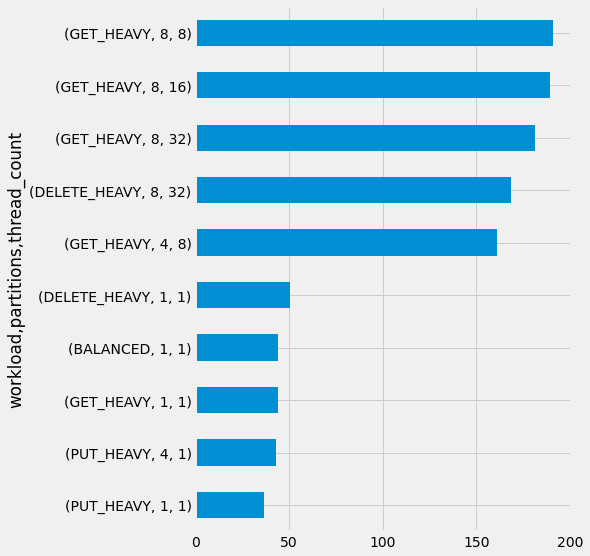

In [162]:
x = normed_results.sort_values('sum', ascending=False)
display(x.head())
display(x.tail())
pd.concat([x['sum'].head(), x['sum'].tail()]).iloc[::-1].plot.barh(figsize=(6,9))

# Analaysis

In [227]:
thread_to_color = dict(zip(sorted(set(spec_values['thread_count'])), colors))
partition_to_ls = dict(zip(sorted(set(spec_values['partitions'])), ['-', '--', ':']))
partition_to_marker = dict(zip(sorted(set(spec_values['partitions'])), ['o', 's', '^']))

Text(0.5, 0.95, 'Overall Performance of Different Workloads w/\nVaried Number of Partitions, each at Optimal Thread Count')

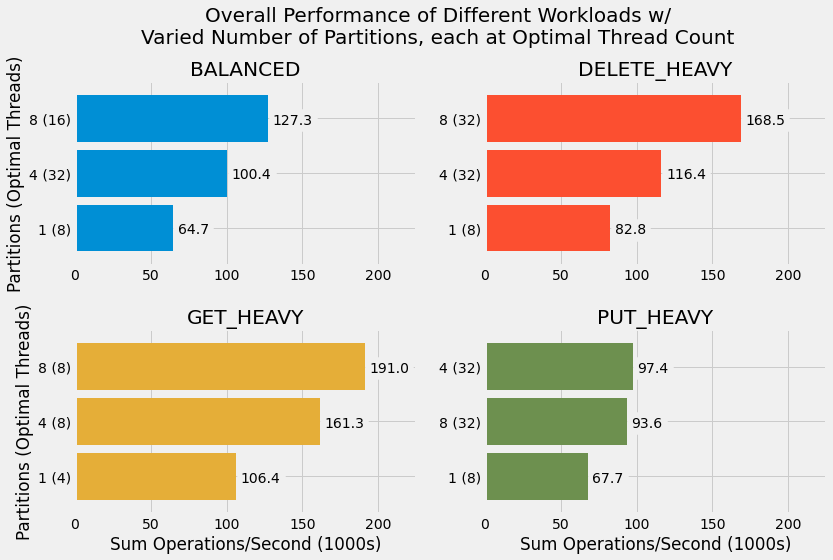

/home/matt/.local/lib/python3.6/site-packages/matplotlib/backends/backend_gtk3.py:195: Warning: Source ID 159 was not found when attempting to remove it
  GLib.source_remove(self._idle_draw_id)


In [280]:
def select_highest_performing_thread_count(df):
    s = df.set_index('thread_count')['sum']
    i = s.idxmax()
    return pd.Series({'thread_count': i, 'sum': s[i]})

fig = plt.figure(figsize=(12, 8))
for ax_i, (color, (workload, workload_df)) in enumerate(zip(colors, normed_results.groupby('workload'))):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    workload_df = workload_df.reset_index().groupby('partitions').apply(select_highest_performing_thread_count)
    x = workload_df.reset_index().set_index(['partitions', 'thread_count'])['sum'].sort_values(ascending=True)
    x.plot.barh(ax=ax, color=color, width=0.85)
    for i, v in enumerate(x):
        ax.text(v + 3, i - 0.1, str(round(v, 1)), bbox=dict(facecolor='#f0f0f0', alpha=1))
    
    ax.set_yticklabels([f'{int(p)} ({int(t)})' for p,t in x.index])
    
    plt.xlim(0, 225)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Partitions (Optimal Threads)')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.35, top=0.82)
fig.suptitle('Overall Performance of Different Workloads w/\n'
             'Varied Number of Partitions, each at Optimal Thread Count', 
             y=0.95, size=20)

Text(0.5, 0.95, 'Impact of Thread Count on Different Workloads w/ 8 Partitions')

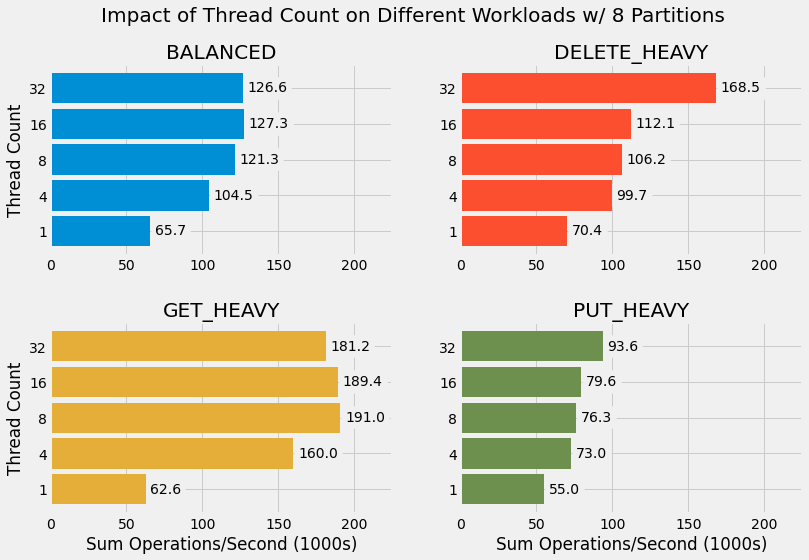

/home/matt/.local/lib/python3.6/site-packages/matplotlib/backends/backend_gtk3.py:195: Warning: Source ID 143 was not found when attempting to remove it
  GLib.source_remove(self._idle_draw_id)


In [272]:
fig = plt.figure(figsize=(12, 8))
x = normed_results.reset_index()
x = x[x['partitions'] == 8]
for ax_i, (color, (workload, workload_df)) in enumerate(zip(colors, x.groupby('workload'))):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    x = workload_df.set_index('thread_count')['sum'].sort_index()
    x.plot.barh(ax=ax, color=color, width=0.85)
    for i, v in enumerate(x):
        ax.text(v + 3, i - 0.1, str(round(v, 1)), bbox=dict(facecolor='#f0f0f0', alpha=1))
    
    plt.xlim(0, 225)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Thread Count')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.35, top=0.85)
fig.suptitle('Impact of Thread Count on Different Workloads w/ 8 Partitions', 
             y=0.95, size=20)

Text(0.5, 0.95, 'Impact of Number of Partitions on Different Workloads w/ 32 Threads')

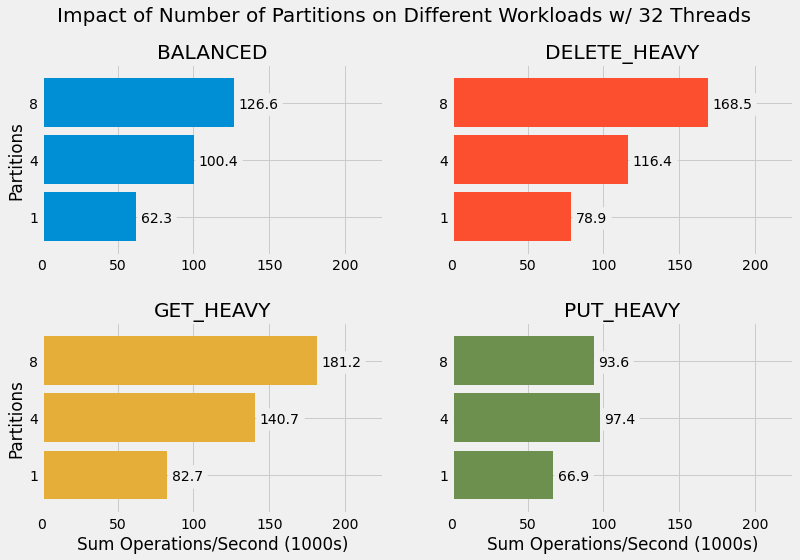

/home/matt/.local/lib/python3.6/site-packages/matplotlib/backends/backend_gtk3.py:195: Warning: Source ID 145 was not found when attempting to remove it
  GLib.source_remove(self._idle_draw_id)


In [273]:
fig = plt.figure(figsize=(12, 8))
x = normed_results.reset_index()
x = x[x['thread_count'] == 32]
for ax_i, (color, (workload, workload_df)) in enumerate(zip(colors, x.groupby('workload'))):
    ax = fig.add_subplot(2, 2, 1+ax_i)
    ax.set_title(workload)
    
    x = workload_df.set_index('partitions')['sum'].sort_index()
    x.plot.barh(ax=ax, color=color, width=0.85)
    for i, v in enumerate(x):
        ax.text(v + 3, i - 0.1, str(round(v, 1)), bbox=dict(facecolor='#f0f0f0', alpha=1))
    
    plt.xlim(0, 225)
    if ax_i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if ax_i%2==0:
        ax.set_ylabel('Partitions')
    else:
        ax.set_ylabel('')
fig.subplots_adjust(hspace=0.35, top=0.85)
fig.suptitle('Impact of Number of Partitions on Different Workloads w/ 32 Threads', 
             y=0.95, size=20)

Text(0.5, 0.95, 'Overall Performance of Different Workloads w/ Varied Number of Partitions and Thread Count')

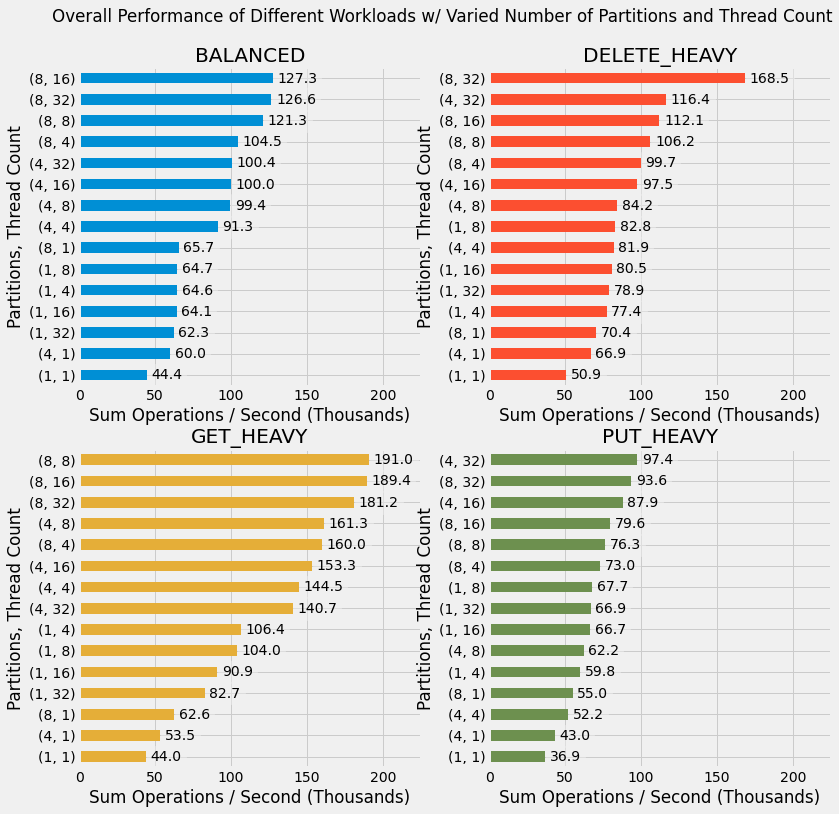

/home/matt/.local/lib/python3.6/site-packages/matplotlib/backends/backend_gtk3.py:195: Warning: Source ID 71 was not found when attempting to remove it
  GLib.source_remove(self._idle_draw_id)


In [232]:
fig = plt.figure(figsize=(12, 12))
for i, (color, (workload, workload_df)) in enumerate(zip(colors, normed_results.groupby('workload'))):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(workload)
    workload_df = workload_df.reset_index().set_index(['partitions', 'thread_count'])
    x = workload_df['sum'].sort_values(ascending=True)
    x.plot.barh(ax=ax, color=color)
    for i, v in enumerate(x):
        ax.text(v + 3, i - 0.2, str(round(v, 1)), bbox=dict(facecolor='#f0f0f0', alpha=0.5))
    plt.xlim(0, 225)
    if i>=2:
        ax.set_xlabel('Sum Operations/Second (1000s)')
    if i%2==0:
        ax.set_ylabel('Partitions, Thread Count')
    else:
        ax.set_ylabel('')
fig.suptitle('Overall Performance of Different Workloads w/ Varied Number of Partitions and Thread Count', y=0.95)

Text(0.5, 1.1, 'Relation Between File Size and Performance w/ Different Workloads and\nVaried Number of Partitions, each at Optimal Thread Count')

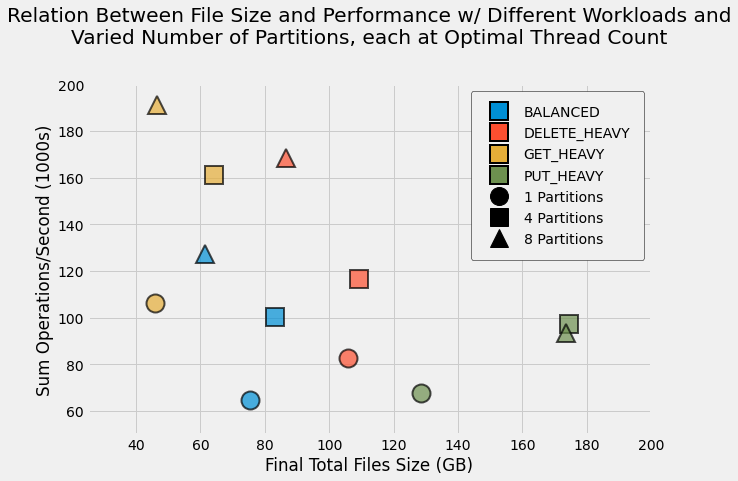

/home/matt/.local/lib/python3.6/site-packages/matplotlib/backends/backend_gtk3.py:195: Warning: Source ID 157 was not found when attempting to remove it
  GLib.source_remove(self._idle_draw_id)


In [279]:

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
for color, (workload, workload_df) in zip(colors, normed_results.groupby('workload')):
    for partition, partition_df in workload_df.reset_index().groupby('partitions'):
        row = partition_df.loc[partition_df['sum'].idxmax()]
        ax.plot([row['final_file_size']], [row['sum']],
                 color=color, marker=partition_to_marker[partition],
                 ms=18, mew=2, mec='k', alpha=0.7)
    ax.plot([-1], [-1], color=color, ls='None', ms=18, mew=2, mec='k', marker='s', label=f'{workload}')
    

for partition, marker in partition_to_marker.items():
    ax.plot([-1], [-1], marker=marker, color='k', ls='None', ms=18, label=f'{partition} Partitions')


ax.set_xlabel('Final Total Files Size (GB)')
ax.set_ylabel('Sum Operations/Second (1000s)')
ax.legend(loc='upper right', frameon=True, framealpha=1, edgecolor='k', borderpad=1)
ax.set_xlim(25, 200)
ax.set_ylim(50, 200)
ax.set_title('Relation Between File Size and Performance w/ Different Workloads and'
             '\nVaried Number of Partitions, each at Optimal Thread Count', y=1.1)

# Time Dependent Analysis

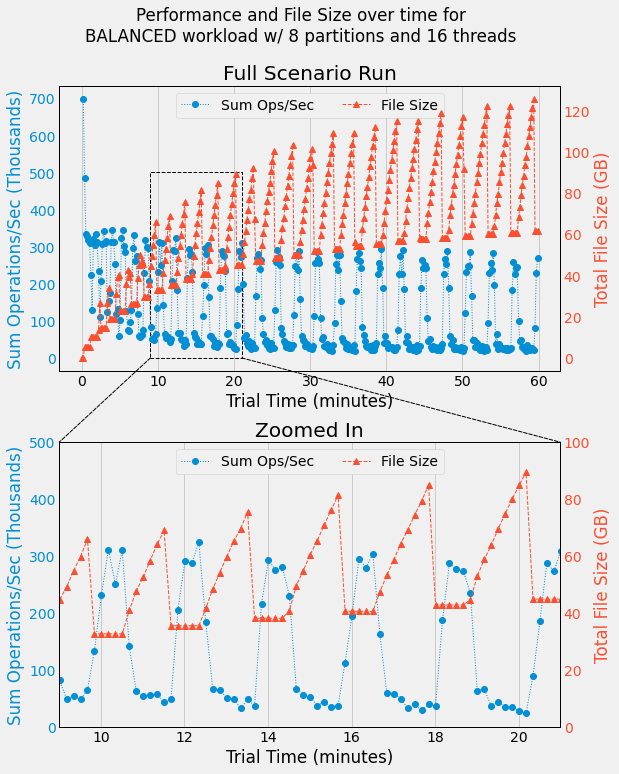

/home/matt/.local/lib/python3.6/site-packages/matplotlib/backends/backend_gtk3.py:195: Warning: Source ID 161 was not found when attempting to remove it
  GLib.source_remove(self._idle_draw_id)


In [281]:
import matplotlib.patches as patches


r = grouped_results
r = r[r['workload'] == 'BALANCED']
r = r[r['partitions'] == 8]
r = r[r['thread_count'] == 16]
assert len(r) == 1
r = r.iloc[0]
x = r['results']
x = x.copy()

t = x['t'] / 60
ops_sec = (x[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
            diff(x['t']))
ops_sec /= 1000

def plot_ops_size(index):
    ax1 = fig.add_subplot(2, 1, index)
    ax2 = ax1.twinx()

    l1, = ax1.plot(t[1::], ops_sec, color=colors[0], label='Sum Ops/Sec', marker='o', lw=1, ls=':')
    l2, = ax2.plot(t, x['file_size'] / 1e9, color=colors[1], label='File Size', marker='^', lw=1, ls='--')

    ax1.grid(False, axis='y')
    ax2.grid(False, axis='y')
    ax1.legend([l1, l2], [l1.get_label(), l2.get_label()],
               loc='upper center', ncol=2, framealpha=1)
    ax1.set_ylabel('Sum Operations/Sec (Thousands)', color=colors[0])
    ax1.tick_params(axis='y', colors=colors[0])
    ax2.set_ylabel('Total File Size (GB)', color=colors[1])
    ax2.tick_params(axis='y', colors=colors[1])
    ax1.set_xlabel('Trial Time (minutes)')
    return ax1, ax2

with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
    fig = plt.figure(figsize=(8,11))
    fig.subplots_adjust(hspace=0.25)

    ax1f, ax2f = plot_ops_size(1)
    rect = patches.Rectangle((9,0),12,500, linewidth=1, edgecolor='k', facecolor='none', ls='--')
    ax1f.add_patch(rect)
    ax1f.set_title('Full Scenario Run')

    ax1z, ax2z = plot_ops_size(2)
    ax1z.set_title('Zoomed In')


    for a,b in [[(9,0), (9, 500)], [(21,0), (21, 500)]]:
        conn = patches.Cocon = patches.ConnectionPatch(xyA=a, xyB=b, coordsA="data", coordsB="data",
                                                       axesA=ax1f, axesB=ax1z, color='k', lw=1, ls='--')
        ax1f.add_artist(conn)

    ax1z.set_xlim(9, 21)
    ax1z.set_ylim(0, 500)
    ax2z.set_ylim(0, 100)

    fig.suptitle('Performance and File Size over time for\n' +
                 f'{r["workload"]} workload w/ {r["partitions"]} partitions and {r["thread_count"]} threads'
                 , y=0.98)


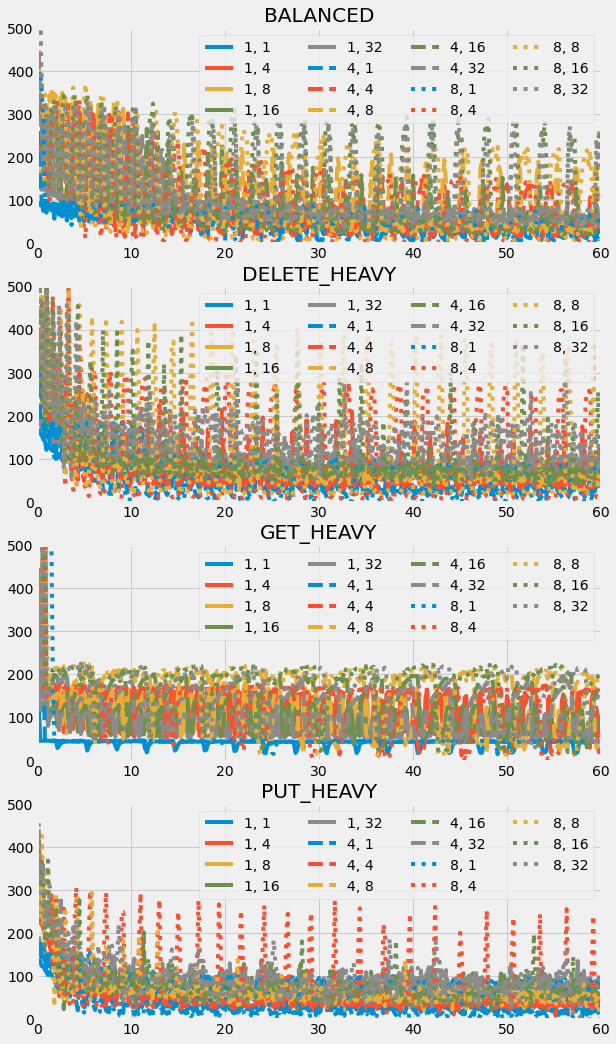

In [10]:
def diff(x):
    return x.iloc[1::].reset_index(drop=True) - x.iloc[:-1:].reset_index(drop=True)


fig = plt.figure(figsize=(9, 17))
for i, (workload, workload_df) in enumerate(grouped_results.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)
    #print(workload, len(workload_df))
    
    for spec_id, spec_row in workload_df.sort_values(['partitions', 'thread_count']).iterrows():
        #print(workload, f"{spec_row['partitions']}, {spec_row['thread_count']}")
        row_results = spec_row['results']
        t = row_results['t'] / 60
        ops_sec = (row_results[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
                   diff(row_results['t']))
        ops_sec /= 1000
        ax.plot(t.iloc[1::], ops_sec,
                label=f"{spec_row['partitions']}, {spec_row['thread_count']}",
                color=thread_to_color[spec_row['thread_count']],
                ls=partition_to_ls[spec_row['partitions']])
    ax.legend(loc='upper right', ncol=4)
    ax.set_title(workload)
    plt.ylim(0, 500)
    plt.xlim(0, 60)
#plt.xlim(0, 5)

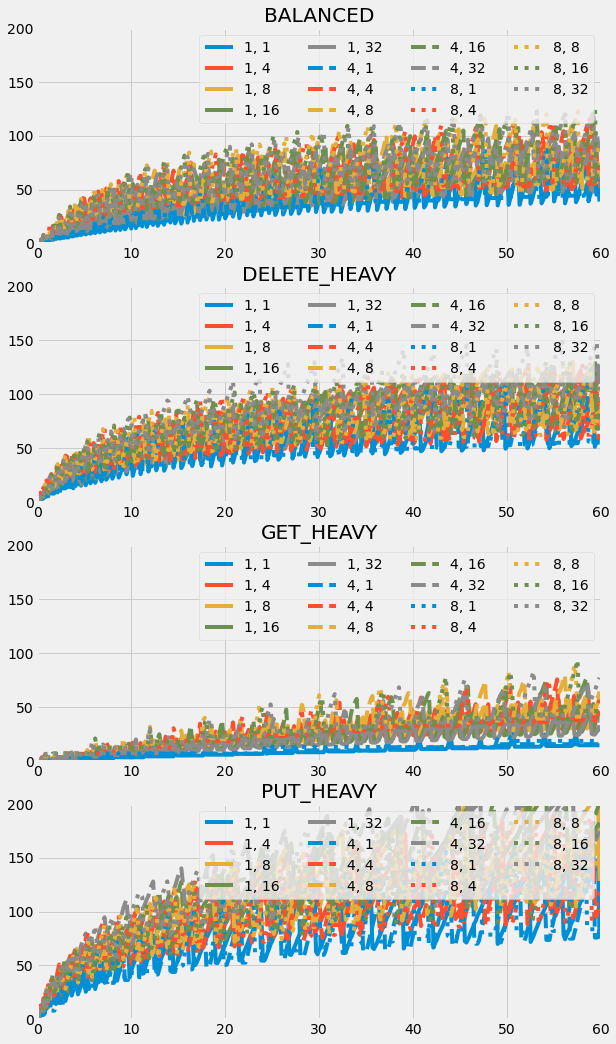

In [11]:
fig = plt.figure(figsize=(9, 17))
for i, (workload, workload_df) in enumerate(grouped_results.groupby('workload')):
    ax = fig.add_subplot(4, 1, i+1)    
    for spec_id, spec_row in workload_df.sort_values(['partitions', 'thread_count']).iterrows():
        row_results = spec_row['results']
        ax.plot(row_results['t'] / 60, row_results['file_size'] / 1e9,
                label=f"{spec_row['partitions']}, {spec_row['thread_count']}",
                color=thread_to_color[spec_row['thread_count']],
                ls=partition_to_ls[spec_row['partitions']])
    ax.legend(loc='upper right', ncol=4)
    ax.set_title(workload)
    plt.ylim(0, 200)
    plt.xlim(0, 60)


Text(0.5, 0.95, 'Overall Performance of Different Workloads w/ Varied Number of Partitions and Thread Count')

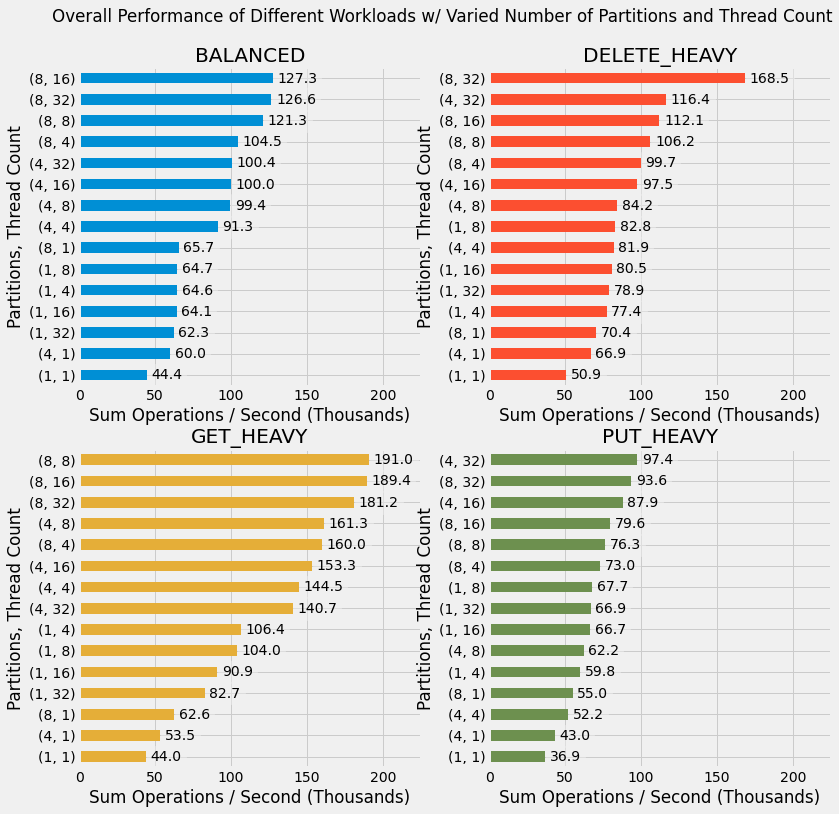

/home/matt/.local/lib/python3.6/site-packages/matplotlib/backends/backend_gtk3.py:195: Warning: Source ID 13 was not found when attempting to remove it
  GLib.source_remove(self._idle_draw_id)


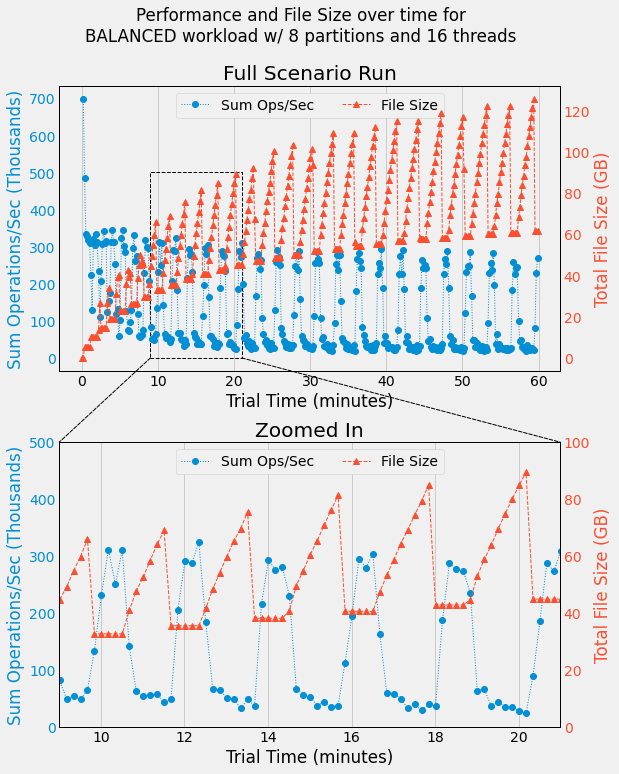